The good way to understand how the neural network learns a time series pattern without the extra noise and complexity of real financial data to approximate sinusoid.

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os

Now the Data generation, the number of points and the number of cycles to generate a sine wave.

In [29]:
N_POINTS = 1500
N_CYCLES = 10

# The number of past time steps to use as input to predict the next time step.
SEQUENCE_LENGTH = 50
TRAIN_RATIO = 0.70
VALIDATION_RATIO = 0.15

In [30]:
RESULTS_DIR = "sinusoid_ffnn_model_res"
EPOCHS = 25
BATCH_SIZE = 32

Generating sinusiud data, remove(comment if need for future use) noise from previous code.

In [31]:
print("--- Generating Sinusoid Data ---")
# Create a time vector
time = np.linspace(0, N_CYCLES * 2 * np.pi, N_POINTS)
# Generate the sine wave
sin_wave = np.sin(time)
#small amount of random noise to make it slightly more realistic
# noise = np.random.normal(0, 0.05, N_POINTS)
# sin_wave_noisy = sin_wave + noise
sin_wave_noisy = sin_wave

print(f"   Generated {N_POINTS} data points.")
# Return as a DataFrame
pd.DataFrame({'Value': sin_wave_noisy})

--- Generating Sinusoid Data ---
   Generated 1500 data points.


,Value
0,0.000000e+00
1,4.190357e-02
2,8.373353e-02
3,1.254164e-01
4,1.668790e-01
...,...
1495,-1.668790e-01
1496,-1.254164e-01
1497,-8.373353e-02
1498,-4.190357e-02


In [32]:
print("---Preparing Data for FFNN ---")

# Extract values and reshape for the scaler
values = sin_wave_noisy.reshape(-1, 1)

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)

# Create sequences
X, y = [], []
for i in range(len(scaled_data) - SEQUENCE_LENGTH-100):
    X.append(scaled_data[i:(i + SEQUENCE_LENGTH), 0])
    y.append(scaled_data[i + SEQUENCE_LENGTH+10, 0])
X, y = np.array(X), np.array(y)

# Use the first 1000 for training and validation, and the remaining 500 for testing
train_val_size = 1000
test_size = 500

# Calculate the actual number of samples available after creating sequences
available_samples = len(X)

# Ensure the requested sizes do not exceed available data
if train_val_size + test_size > available_samples:
    print(f"Warning: Requested split size ({train_val_size + test_size}) exceeds available data ({available_samples}). Adjusting sizes.")
    # Adjust sizes proportionally or as needed
    # For this case, we'll just use all available data
    train_val_size = int(available_samples * (train_val_size / (train_val_size + test_size)))
    test_size = available_samples - train_val_size


X_train_val, y_train_val = X[:train_val_size], y[:train_val_size]
X_test, y_test = X[train_val_size:train_val_size + test_size], y[train_val_size:train_val_size + test_size]

# Now split the train_val_set into training and validation
# Use the first 800 for training and the next 200 for validation
train_size = 800
validation_size = 200

# Ensure the requested training and validation sizes do not exceed the train_val_size
if train_size + validation_size > len(X_train_val):
     print(f"Warning: Requested train/validation split size ({train_size + validation_size}) exceeds available training/validation data ({len(X_train_val)}). Adjusting sizes.")
     # Adjust sizes proportionally or as needed
     train_size = int(len(X_train_val) * (train_size / (train_size + validation_size)))
     validation_size = len(X_train_val) - train_size


X_train, y_train = X_train_val[:train_size], y_train_val[:train_size]
X_val, y_val = X_train_val[train_size:train_size + validation_size], y_train_val[train_size:train_size + validation_size]


print(f"   Training set size:   {len(X_train)} samples")
print(f"   Validation set size: {len(X_val)} samples")
print(f"   Test set size:       {len(X_test)} samples")

---Preparing Data for FFNN ---
   Training set size:   720 samples
   Validation set size: 180 samples
   Test set size:       450 samples


In [33]:
print("--- Building, Training, and Evaluating Model ---")

model = Sequential([
  Input(shape=(SEQUENCE_LENGTH, 1)),
  Flatten(),
  Dense(64, activation='sigmoid'),
  Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

print("\n   Training the model...")
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1)

print("\n   Evaluating model performance...")
loss = model.evaluate(X_test, y_test)
print(f"   Test loss: {loss:.4f}")
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actuals to their original scale
predictions_actual = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("\n   Evaluating model performance...")
mae = mean_absolute_error(y_test_actual, predictions_actual)
print(f"   Mean Absolute Error (MAE): {mae:.4f}")

--- Building, Training, and Evaluating Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)


   Training the model...
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5166 - val_loss: 0.1192
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0979 - val_loss: 0.0310
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0218 - val_loss: 0.0041
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 3.5020e-04
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7515e-04 - val_loss: 1.3611e-04
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5261e-04 - val_loss: 1.2760e-04
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3366e-04 - val_loss: 1.2337e-04
Epoch 8/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2886e-04 - val_loss: 1.1665e-04
Epoch 9/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2260e-04 - val_loss: 1.1138e-04
Epoch 10/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1964e-04 - val_loss: 1.0718e-04
Epoch 11/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1421e-04 - val_loss

....  Generating plot to visualize approximation...


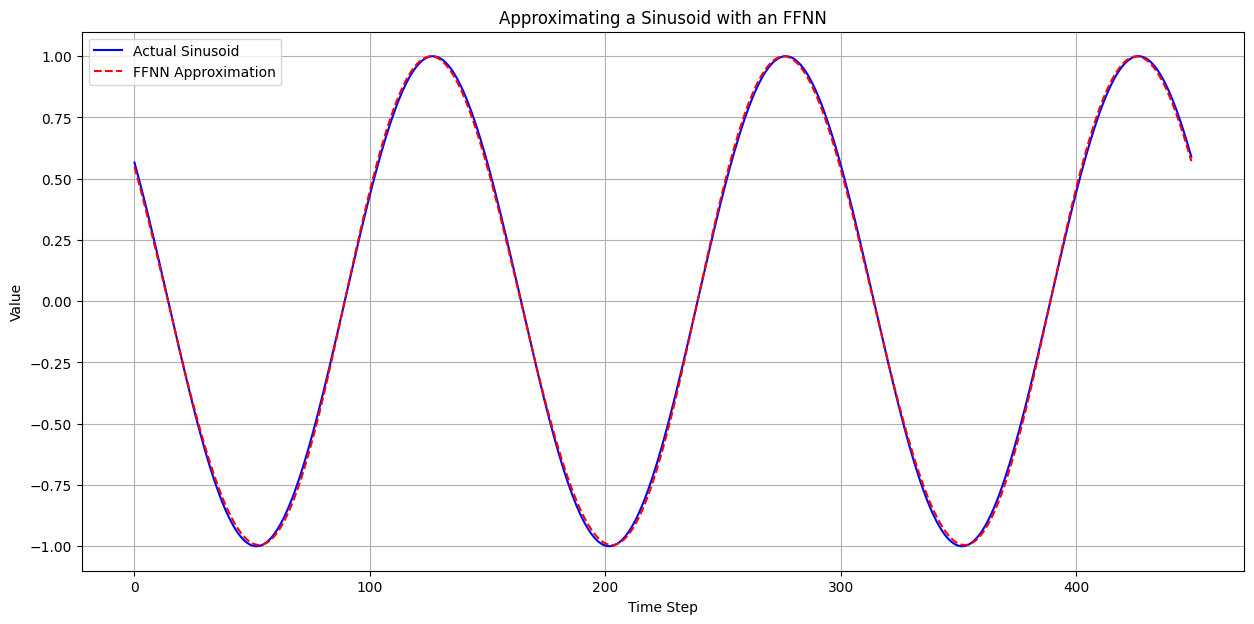

   Plot saved to 'sinusoid_ffnn_model_res/sinusoid_approximation.png'


In [34]:
print("....  Generating plot to visualize approximation...")
os.makedirs(RESULTS_DIR, exist_ok=True)
plot_path = os.path.join(RESULTS_DIR, 'sinusoid_approximation.png')

# Create an index for the x-axis of the plot
test_indices = np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test_actual))

plt.figure(figsize=(15, 7))
plt.plot(y_test_actual, color='blue', label='Actual Sinusoid')
plt.plot(predictions_actual, color='red', linestyle='--', label='FFNN Approximation')
plt.title('Approximating a Sinusoid with an FFNN')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()
print(f"   Plot saved to '{plot_path}'")

In [35]:
print("First 5 unscaled data points of y_test_actual:")
display(y_test_actual[:5])

print("\nFirst 5 unscaled data points of predictions_actual:")
display(predictions_actual[:5])

First 5 unscaled data points of y_test_actual:


array([[0.56587357],
       [0.53082737],
       [0.49484869],
       [0.45800071],
       [0.42034817]])


First 5 unscaled data points of predictions_actual:


array([[0.54766494],
       [0.5128699 ],
       [0.47723493],
       [0.4408214 ],
       [0.40369335]], dtype=float32)

In [36]:
print(f"Number of data points used to calculate MAE: {len(y_test_actual)}")
print(f"Number of data points used to calculate MSE: {len(predictions_actual)}")

Number of data points used to calculate MAE: 450
Number of data points used to calculate MSE: 450


In [37]:

# Find indices where predictions_actual is close to 1
indices_at_1_pred = np.where(np.isclose(predictions_actual, 1, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where predictions_actual is close to 1:", indices_at_1_pred)

# Find indices where predictions_actual is close to 0
indices_at_0_pred = np.where(np.isclose(predictions_actual, 0, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where predictions_actual is close to 0:", indices_at_0_pred)

# Find indices where y_test_actual is close to 1
indices_at_1_actual = np.where(np.isclose(y_test_actual, 1, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where y_test_actual is close to 1:", indices_at_1_actual)

# Find indices where y_test_actual is close to 0
indices_at_0_actual = np.where(np.isclose(y_test_actual, 0, atol=0.05))[0] # Using a tolerance due to approximation
print("Timestep where y_test_actual is close to 0:", indices_at_0_actual)


# Find the time step of the maximum value 1 in prediction_actual
index_of_max_actual = np.argmax(predictions_actual)
print(f"At {index_of_max_actual} timestep the max value close to 1 is {predictions_actual[index_of_max_actual]}")


Timestep where predictions_actual is close to 1: [119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433]
Timestep where predictions_actual is close to 0: [ 13  14  15  89  90 163 164 165 239 240 313 314 315 388 389 390]
Timestep where y_test_actual is close to 1: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434]
Timestep where y_test_actual is close to 0: [ 14  15  89  90 164 165 239 240 313 314 315 388 389 390]
At 126 timestep the max value close to 1 is [0.99945813]


In [38]:
zero_values = predictions_actual[indices_at_0_pred]

# Find the index within zero_values that is closest to 0
closest_to_zero_index_in_list = np.argmin(np.abs(zero_values))

# Get the actual index from the original zero_indices list
closest_to_zero_timestep = indices_at_0_pred[closest_to_zero_index_in_list]
print(f"At {closest_to_zero_timestep} timestep the value close to 0 is {predictions_actual[closest_to_zero_timestep]}")


At 314 timestep the value close to 0 is [-0.00033736]
